## 0. 데이터불러오기

MNIST 데이터셋을 이용한 분류 모델 연습하기

In [9]:
import ssl
import urllib
from sklearn.datasets import fetch_openml

# SSL 인증서 검증을 비활성화
ssl._create_default_https_context = ssl._create_unverified_context

# MNIST 데이터셋 로드
mnist = fetch_openml('mnist_784', version=1)

# 데이터 확인
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [20]:
X = mnist['data']
y = mnist['target']

In [26]:
X.shape

(70000, 784)

In [22]:
y.shape

(70000,)

28 x 28 픽셀로 이루어진 데이터를 시각화해보자.

In [52]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [42]:
type(X.head(1))

pandas.core.frame.DataFrame

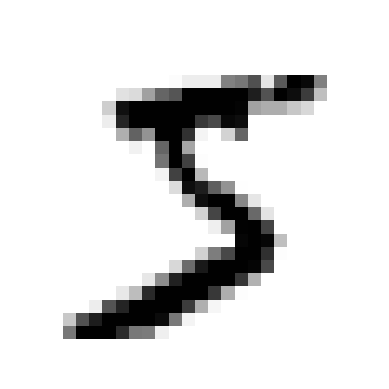

In [48]:
some_digit = X.iloc[0].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [49]:
y[0]

'5'

자료를 더 자세히 조사하기전에 `훈련 데이터셋`과 `테스트 데이터셋`을 분리하자!

In [89]:
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1. 이진 분류기 훈련

숫자 5와 5가 아닌 숫자를 구별하는 모델을 만들어보자!

In [91]:
y_train5 = (y_train == 5)
y_test5 = (y_test == 5)

In [94]:
# 고유 클래스 확인
print("Unique classes in y_train5:", y_train5.unique())

Unique classes in y_train5: [ True False]


In [92]:
from sklearn.linear_model import SGDClassifier

In [95]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train5)

SGDClassifier(random_state=42)

In [96]:
sgd_clf.predict([some_digit])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 1-2 성능 측정하기

In [108]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

cross_val_score() 메서드를 사용하지 않고 교차검증을 직접구현하면 아래와 같이 만들 수 있다.  
(교차검증로직을 커스텀하거나 조금 더 많은 부분을 제어하고 싶을때!)

In [112]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train5_folds = y_train5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train5_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
        

0.9669
0.91625
0.96785


cross_val_score( )메서드를 이용한 교차검증.

In [113]:
from sklearn.model_selection import cross_val_score


In [114]:
cross_val_score(sgd_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [116]:
from sklearn.base import BaseEstimator

# 모든 답을 5가아님이라고 말하는 모델 생성
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

never5_clf = Never5Classifier()
cross_val_score(never5_clf, X_train, y_train5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

`불균형한 데이터셋`을 다룰때는 `정확도`는 분류기의 성능 지표로 사용하기 어렵다.  

전부 5가 아니라고 예측해도 5가 아닌데이터가 90%이상이기때문에 정확도도 90% 이상이 나온다!

## 1-3 오차행렬을 활용하자!

In [118]:
from sklearn.model_selection import cross_val_predict

In [119]:
y_train5_pred = cross_val_predict(sgd_clf, X_train, y_train5, cv=3)

In [120]:
from sklearn.metrics import confusion_matrix

In [122]:
confusion_matrix(y_train5, y_train5_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [124]:
from sklearn.metrics import precision_score, recall_score

In [126]:
#정밀도 : 5라고 예측한 것(양성)중에 5라고 맞춘것
precision_score(y_train5, y_train5_pred)

np.float64(0.8370879772350012)

In [127]:
#재현율 : 실제 5인 결과중에 올바르게 예측된 것
recall_score(y_train5, y_train5_pred)

np.float64(0.6511713705958311)

In [128]:
from sklearn.metrics import f1_score

In [129]:
#f1_score : 정밀도, 재현율의 조화평균
#정밀도와 재현율이 비슷한 분류기에서는 F1의 점수가 높다. 하지만 이것이 항상 바람직한 것은 아니다.
#상황에 따라 정밀도가 중요할수도, 재현율이 중요할 수 도 있다.
f1_score(y_train5, y_train5_pred)

np.float64(0.7325171197343847)

In [132]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [136]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train5, cv=3, method="decision_function")

In [137]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [138]:
from sklearn.metrics import precision_recall_curve

precision, recalls, threshold = precision_recall_curve(y_train5, y_scores)

In [164]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 글꼴 설정 (여기서는 'Malgun Gothic'을 사용)
plt.rcParams['font.family'] = 'D2Coding'

# 한글 폰트 적용 확인
print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

['/System/Library/AssetsV2/com_apple_MobileAsset_Font7/96af7ec9e88d5dae450d3162213f92a7b1129430.asset/AssetData/YuppySC-Regular.otf', '/System/Library/Fonts/Supplemental/Copperplate.ttc', '/System/Library/Fonts/Supplemental/NotoSansMandaic-Regular.ttf', '/System/Library/Fonts/GeezaPro.ttc', '/System/Library/Fonts/Supplemental/Kefa.ttc', '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/aa99d0b2bad7f797f38b49d46cde28fd4b58876e.asset/AssetData/Xingkai.ttc', '/System/Library/Fonts/Supplemental/Damascus.ttc', '/System/Library/Fonts/Supplemental/NotoSansKhudawadi-Regular.ttf', '/System/Library/Fonts/Supplemental/STIXIntSmReg.otf', '/System/Library/Fonts/Supplemental/Tamil MN.ttc', '/Users/geunskoo/Library/Fonts/Pretendard-ExtraBold.ttf', '/Users/geunskoo/Library/Fonts/D2CodingBold-Ver1.3.2-20180524.ttf', '/System/Library/AssetsV2/com_apple_MobileAsset_Font7/988d97c87efe350cfa398b9ae4e822431f92d59b.asset/AssetData/Srisakdi.ttc', '/System/Library/Fonts/Supplemental/NotoSansHatran-Regular.

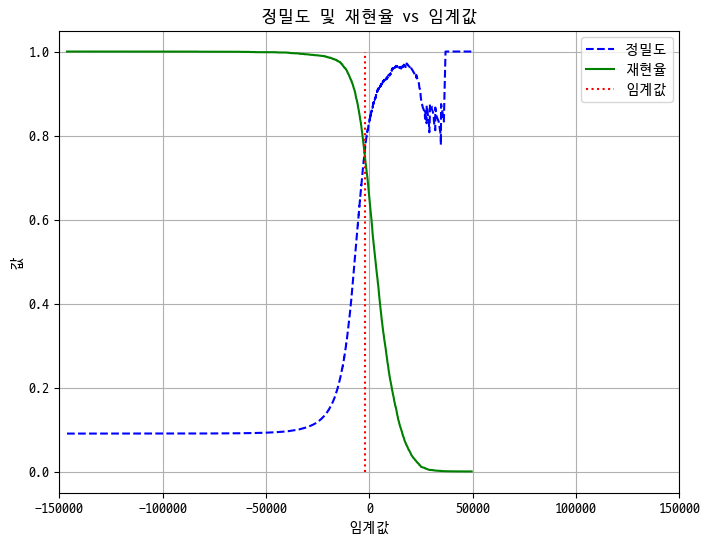

In [166]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precision, recalls, threshold):
    plt.figure(figsize=(8, 6))
    
    # 정밀도와 재현율 곡선 그리기
    plt.plot(threshold, precision[:-1], 'b--', label='정밀도')
    plt.plot(threshold, recalls[:-1], 'g-', label='재현율')
    
    # 임계값을 강조 표시
    close_default_threshold = threshold[np.argmax(precision[:-1] >= recalls[:-1])]
    plt.plot([close_default_threshold, close_default_threshold], [0, 1], 'r:', label='임계값')

    # 범례 추가
    plt.legend(loc='best')

    # 축 이름 추가
    plt.xlabel('임계값')
    plt.ylabel('값')

    #축 간격
    plt.xlim(-150000, 150000)

    # 그리드 추가
    plt.grid(True)

    plt.title('정밀도 및 재현율 vs 임계값')


plot_precision_recall_vs_threshold(precision, recalls, threshold)
plt.show()

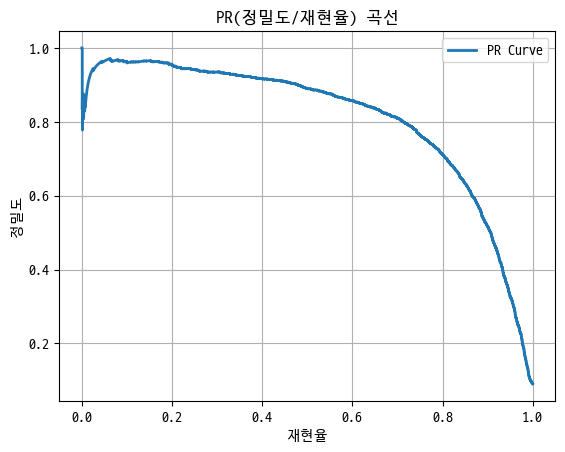

In [178]:
def plot_pr_curve(precision, recalls, label=None):
    plt.plot(recalls, precision, linewidth=2, label=label)

    # 범례 추가
    plt.legend(loc='best')

    # 축 이름 추가
    plt.xlabel('재현율')
    plt.ylabel('정밀도')

    # 그리드 추가
    plt.grid(True)

    plt.title('PR(정밀도/재현율) 곡선')

plot_pr_curve(precision, recalls, 'PR Curve')
plt.show()

ROC 곡선 : 수신기 조작 특성 곡선도 이진분류에서 널리 사용하는 도구이다.  

정밀도/재현율 곡선과 매우 비슷하지만 ROC곡선은 `거짓 양성 비율`(1-특이도)에 대한 `진짜 양성 비율`(재현율) 이다.

In [167]:
from sklearn.metrics import roc_curve

In [168]:
fpr, tpr, threshold = roc_curve(y_train5, y_scores)

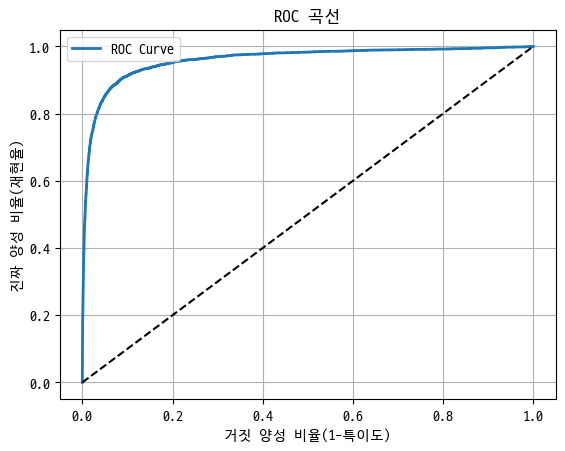

In [173]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')

    # 범례 추가
    plt.legend(loc='best')

    # 축 이름 추가
    plt.xlabel('거짓 양성 비율(1-특이도)')
    plt.ylabel('진짜 양성 비율(재현율)')

    # 그리드 추가
    plt.grid(True)

    plt.title('ROC 곡선')

plot_roc_curve(fpr, tpr, 'ROC Curve')
plt.show()

재현율이 높을수록 거짓 양성 비율이 늘어난다라는 트레이드오프가 존재함.

주대각선의 점선은 랜덤한 분류기의 ROC 곡선이다. 좋은 분류기는 점선으로 부터 최대한 멀리 떨어져 있어야한다.(왼쪽 모서리)

`곡선아래의 면적(AUC)`를 측정하면 분류기들을 비교할 수 있다.
완벽한 분류기는 ROC의 AUC가 1이고, 완전한 랜덤 분류기는 0.5이다

In [174]:
from sklearn.metrics import roc_auc_score

In [175]:
roc_auc_score(y_train5, y_scores)

np.float64(0.9604938554008616)

* ROC곡선과 정밀도/재현율(PR)곡선 중 어떤 것을 사용하는것이 좋을까?  

일반적인 법칙으로는 양성클래스가 드물거나 거짓 음성보다 거짓 양성이 더 중요할 때 PR곡선을 사용한다.  
그렇지 않으면 ROC곡선을 사용한다.

* SGDC와 RandomForest 모델의 AUC를 비교해보자!

In [179]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train5, cv=3, method='predict_proba')

In [181]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train5, y_scores_forest)

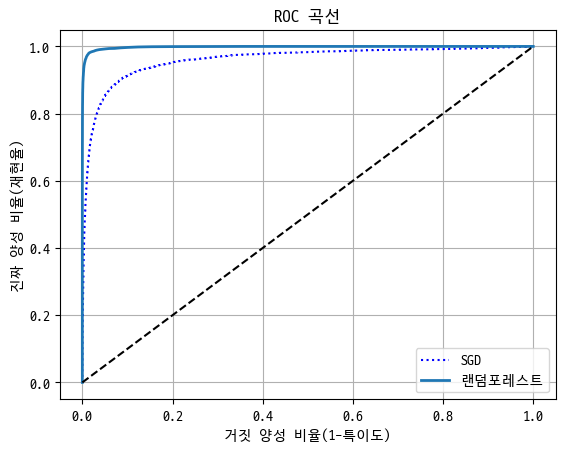

In [183]:
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "랜덤포레스트")
plt.show()

In [184]:
roc_auc_score(y_train5, y_scores_forest)

np.float64(0.9983296721818179)